In [220]:
# General
import numpy as np
import matplotlib.pyplot as plt
import time

# Linear regression
import sklearn.linear_model

# CNN
import torch
from torch import nn, cuda
from torch.utils.data import DataLoader, Dataset

# Data preprocessing

In [221]:
# Load digits array from file
# File is formatted 200 rows per digit, each row representing a 15x16 grayscale image

digits = np.loadtxt('mfeat-pix.txt', usecols=range(240))
digits = digits.reshape(digits.__len__(), 16, 15)

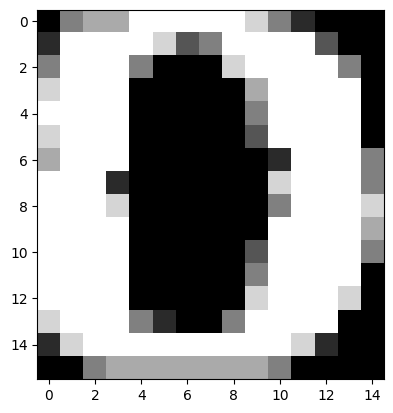

In [222]:
plt.imshow(digits[0], cmap='gray')

In [223]:
# Split the data in train and test data, 50/50
train_digits = np.empty([0, 16, 15])
x_test = np.empty([0, 16, 15])
y_test = np.empty(0)

digits_per_digit = np.array(np.split(digits, 10))

for d in range(10):
    [d_train, d_test] = np.array(np.split(digits_per_digit[d], 2))
    print(d_train.shape)
    train_digits = np.concatenate((train_digits, d_train))
    x_test = np.concatenate((x_test, d_test))
    y_test = np.concatenate((y_test, np.full(d_test.__len__(), d)))

(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)
(100, 16, 15)


In [224]:
# Train data is augmented by shifting in the 8 cardinal directions
x_train_augmented = np.empty([0, 16, 15])
y_train_augmented = np.empty(0)

train_digits_per_digit = np.array(np.split(train_digits, 10))

for d in range(10):
    train_digits_10_chunks = np.array(np.split(train_digits_per_digit[d], 10))
    train_digits_10_chunks = np.concatenate(train_digits_10_chunks[:10])
    # Perform data augmentation by shifting in 8 cardinal directions
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue  # skip the original data
            shifted_digits = np.roll(train_digits_10_chunks, (dx, dy), axis=(1, 2)) #roll used to shift the data
            x_train_augmented = np.concatenate((x_train_augmented, shifted_digits))
            y_train_augmented = np.concatenate((y_train_augmented, np.full(shifted_digits.shape[0], d)))
            #labels for the augmenteddata created using np.full to fill an array of the same length

In [225]:
# Normalize the data
x_test = x_test / x_test.max()
x_train_augmented = x_train_augmented / x_train_augmented.max()

# Linear regression
A basic linear regression to sanity check results from CNN

In [226]:
# Flatten the data
x_train_flat = np.reshape(x_train_augmented, (x_train_augmented.__len__(), -1))
x_test_flat = np.reshape(x_test, (x_test.__len__(), -1))

In [227]:
# Teach basic linear regression with train data, test with test data
lr = sklearn.linear_model.LogisticRegression(solver='saga', tol=0.1)
lr = lr.fit(x_train_flat, y_train_augmented)

print(f'train: {lr.score(x_train_flat, y_train_augmented)}')
print(f'test: {lr.score(x_test_flat, y_test)}')

train: 0.94575
test: 0.963


# CNN

## Pytorch preprocessing

In [228]:
# Special torch arrays
# Taken from mnist_keras_pytorch.ipynb from tutorial
torch_x_train = torch.from_numpy(x_train_augmented).unsqueeze(1)
torch_y_train = torch.from_numpy(y_train_augmented)

torch_x_test = torch.from_numpy(x_test).unsqueeze(1)
torch_y_test = torch.from_numpy(y_test)

In [229]:
# Torch datasets
# Taken from mnist_keras_pytorch.ipynb from tutorial
class DigitsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        X = self.X[index].float()
        Y = self.Y[index].long()
        return X,Y

train_dataset = DigitsDataset(torch_x_train, torch_y_train)

test_dataset = DigitsDataset(torch_x_test, torch_y_test)

In [230]:
# Torch dataloader
# Taken from mnist_keras_pytorch.ipynb from tutorial
if cuda.is_available():
    loader_args = dict(shuffle=True, batch_size=256, num_workers=8, pin_memory=True)
else:
    loader_args = dict(shuffle=True, batch_size=64)

train_loader = DataLoader(train_dataset, **loader_args)

test_loader = DataLoader(test_dataset, **loader_args)

## Epochs setup

In [231]:
# Taken from mnist_keras_pytorch.ipynb from tutorial
def train_epoch(model, train_loader, criterion, optimizer, do_print=True):
    model.train()

    running_loss = 0.0

    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()

    running_loss /= len(train_loader)
    if do_print:
        print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [232]:

# Taken from mnist_keras_pytorch.ipynb from tutorial
def test_model(model, test_loader, criterion, do_print=True, testing_mode=False):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)


            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        if do_print:
            mode = 'Testing' if testing_mode else 'Validation'
            print(mode, ' Loss: ', running_loss)
            print(mode, ' Accuracy: ', acc, '%')
        return running_loss, acc

In [233]:
def train_model(model, train_loader, validate_loader, criterion, optimizer, epochs=10, print_freq=1):
    if print_freq > 0:
        print(model)
    device = torch.device('cuda' if cuda.is_available() else 'cpu')
    model.to(device)

    Train_loss = []
    Validate_loss = []
    Validate_acc = []

    for i in range(epochs):
        do_print = print_freq > 0 and (i == 0 or (i+1) % print_freq == 0)
        if do_print:
            print('Epoch :', i)
        train_loss = train_epoch(model, train_loader, criterion, optimizer, do_print=do_print)
        validate_loss, validate_acc = test_model(model, validate_loader, criterion, do_print=do_print)
        Train_loss.append(train_loss)
        Validate_loss.append(validate_loss)
        Validate_acc.append(validate_acc)
        if do_print:
            print('='*20)

    return Train_loss, Validate_loss, Validate_acc

## Network attempts
https://madebyollin.github.io/convnet-calculator/ can come in very handy when determining the trainable parameters for a convolution layer.

### LeNet-5-like network (Tom)
The LeNet-5 architecture was the first successfully trained CNN - it was even designed for the task we're doing, but on images of 28x28 (hence the "-like").

Its architecture is as follows:
1. Input (1@15x16)
2. Convolution -- (6@15x16)
3. Average pool -- (6@7x8)
4. Convolution -- (16@5x6)
5. Average pool -- (16@2x3)
6. Fully connected layer -- 120 nodes
7. Fully connected layer -- 84 nodes
8. Fully connected output -- one-hot encoding

In [237]:
tom2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,4), padding=2), nn.ReLU(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=384, out_features=240), nn.ReLU(),
    nn.Linear(in_features=240, out_features=60), nn.ReLU(),
    nn.Linear(in_features=60, out_features=10)
)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(tom2.parameters(), weight_decay=1e-5)
optimizer = torch.optim.SGD(tom2.parameters(), lr=0.01, momentum=0.9)

In [238]:
from sklearn.model_selection import KFold

device = torch.device('cuda' if cuda.is_available() else 'cpu')

# Set the number of folds
k_folds = 5

# Create the KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store the performance metrics for each fold
fold_train_loss = []
fold_val_loss = []
fold_val_acc = []

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(torch_x_train)):
    print(f"Fold {fold+1}/{k_folds}")

    # Create the train and validation datasets for this fold
    fold_train_dataset = DigitsDataset(torch_x_train[train_index], torch_y_train[train_index])
    fold_val_dataset = DigitsDataset(torch_x_train[val_index], torch_y_train[val_index])

    # Create the train and validation data loaders for this fold
    fold_train_loader = DataLoader(fold_train_dataset, **loader_args)
    fold_val_loader = DataLoader(fold_val_dataset, **loader_args)

    # Create a new instance of the model for each fold
    tom2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,4), padding=2), nn.ReLU(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=384, out_features=240), nn.ReLU(),
    nn.Linear(in_features=240, out_features=60), nn.ReLU(),
    nn.Linear(in_features=60, out_features=10)
    )

    # Move the model to the device
    tom2.to(device)

    # Create a new instance of the optimizer for each fold
    optimizer = torch.optim.Adam(tom2.parameters(), weight_decay=1e-5)

    # Train the model for this fold
    train_loss, val_loss, val_acc = train_model(tom2, fold_train_loader, fold_val_loader, criterion, optimizer, 15)

    # Store the performance metrics for this fold
    fold_train_loss.append(train_loss)
    fold_val_loss.append(val_loss)
    fold_val_acc.append(val_acc)


Fold 1/5
Sequential(
  (0): Conv2d(1, 1, kernel_size=(5, 4), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=384, out_features=240, bias=True)
  (7): ReLU()
  (8): Linear(in_features=240, out_features=60, bias=True)
  (9): ReLU()
  (10): Linear(in_features=60, out_features=10, bias=True)
)
Epoch : 0
Training Loss:  1.7168302732706069 Time:  0.9188723564147949 s
Validation  Loss:  0.751165018081665
Validation  Accuracy:  75.6875 %
Epoch : 1
Training Loss:  0.5231873974204063 Time:  0.9269344806671143 s
Validation  Loss:  0.3898370087146759
Validation  Accuracy:  86.75 %
Epoch : 2
Training Loss:  0.3281726111471653 Time:  0.931995153427124 s
Validation  Loss:  0.26287745624780656
Validation  Accuracy:  91.9375 %
Epoch : 3
Training Loss:  0.24432081937789918 Time:  0.9401021003723145 s
Valid

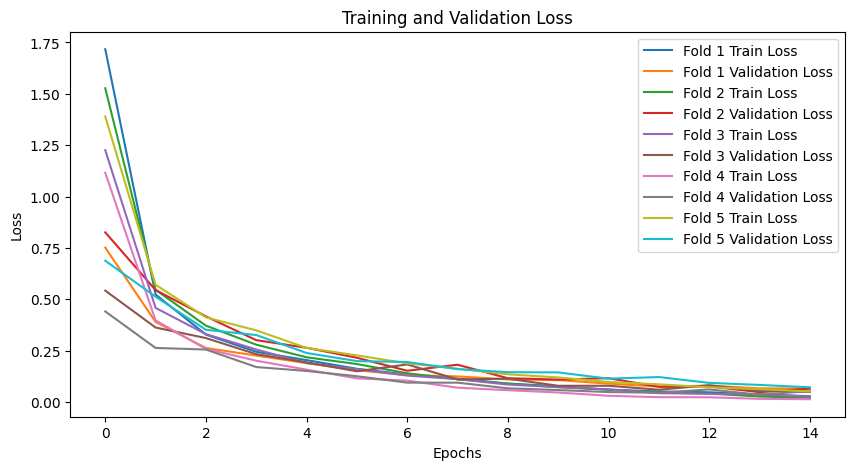

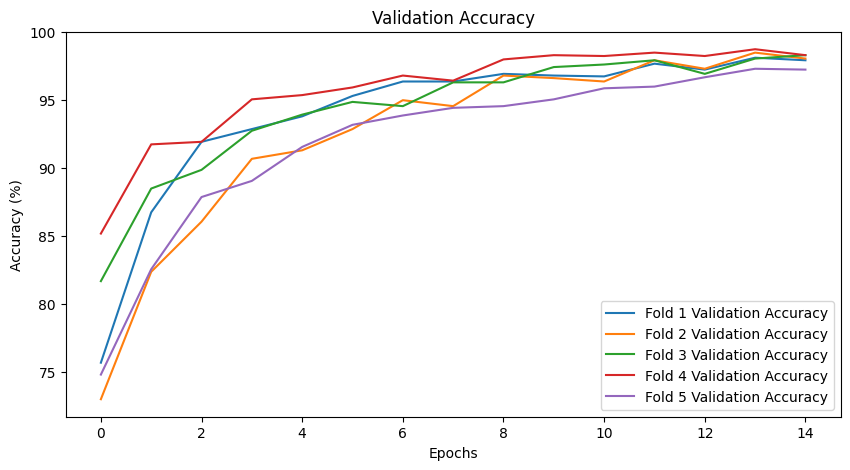

In [239]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for each fold
plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(fold_train_loss[fold], label=f"Fold {fold+1} Train Loss")
    plt.plot(fold_val_loss[fold], label=f"Fold {fold+1} Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the validation accuracy for each fold
plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(fold_val_acc[fold], label=f"Fold {fold+1} Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [240]:
test_loss, test_acc = test_model(tom2, test_loader, criterion, do_print=True, testing_mode=True)

Testing  Loss:  0.13421998973353766
Testing  Accuracy:  97.2 %


### Tom's 2nd attempt

Architecture as follows:
1. Input (1@15x16)
2. Convolution (1@16x16)
3. Convolution (6@16x16)
4. Average pool (6@8x8)
5. FCL 240
6. FCL 60
7. FCL Output -- one-hot encoded